# Amazon Fine Food Reviews KNN Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review

## Importing libraries and loading the dataset :
* Cleaning and handling deduplication of data is already performed.

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn import datasets, neighbors

C:\Users\Prakhar\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
conn = sqlite3.connect('final.sqlite')

In [3]:
data = pd.read_sql_query("""
SELECT *
FROM Reviews""", conn)
data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


In [4]:
data.shape

(364171, 12)

In [5]:
neg_data = data[data['Score'] == 'negative'][0:2500]
pos_data = data[data['Score'] == 'positive'][0:2500]
sample_data = pd.concat([neg_data, pos_data])
sample_data['Score'].value_counts()

positive    2500
negative    2500
Name: Score, dtype: int64

In [6]:
sample_data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
19,138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...,b'one best children book ever written mini ver...
29,138679,150497,0006641040,A1HKYQOFC8ZZCH,"Maria Apolloni ""lanarossa""",2,2,negative,1334707200,"The story is great, the softcover book is disa...",I give five stars to the Maurice Sendak story....,b'give five star mauric sendak stori one star ...


## Time Based Splitting :

In [7]:
# Sorting the sample data using Time column
sorted_sample = sample_data.sort_values(by='Time')
sorted_sample.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...


In [8]:
# Getting the Labels i.e the Score out of the dataframe.
y = sorted_sample['Score']
# Removing the Labels i.e the Score Column from the dataframe as we wont need it to train a KNN.
sorted_sample = sorted_sample.drop(columns='Score')
sorted_sample.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...


In [9]:
# Splitting into Test, Train and Cross-Validation set -
x_train = sorted_sample[0:3000]
y_train = y[0:3000]
x_test = sorted_sample[3000:5000]
y_test = y[3000:5000]

print ("Training Set - ", x_train.shape)
print ("Test Set - ", x_test.shape)

Training Set -  (3000, 11)
Test Set -  (2000, 11)


## Bag of Words Model :

In [10]:
count_vect = CountVectorizer()
x_train = count_vect.fit_transform(x_train['CleanedText'].values)
x_train = x_train.todense()
x_train.shape

(3000, 8535)

In [11]:
x_test = count_vect.transform(x_test['CleanedText'].values)
x_test = x_test.todense()
x_test.shape

(2000, 8535)

#### 10-fold CV for BoW Model :

In [12]:
klist = list(range(1,30,2))
klist

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

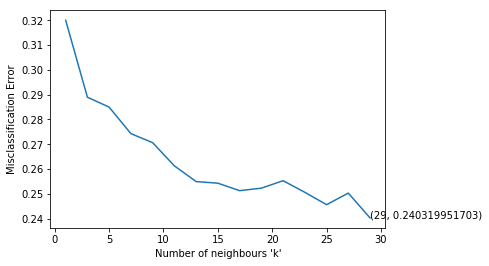

In [13]:
cv_scores = []
for k in klist:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
error = [1 - x for x in cv_scores]
optimal_k = klist[error.index(min(error))]
plt.plot(klist, error)
xy = (optimal_k, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()

In [14]:
# Accuracy on test data;
knn = KNeighborsClassifier(n_neighbors=optimal_k, n_jobs=-1)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
acc = accuracy_score(y_test, y_pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 29 is 74.550000%


## TF-IDF Model :

In [15]:
# Splitting into Test, Train and Cross-Validation set -
x_train = sorted_sample[0:3000]
y_train = y[0:3000]
x_test = sorted_sample[3000:5000]
y_test = y[3000:5000]

print ("Training Set - ", x_train.shape)
print ("Test Set - ", x_test.shape)

Training Set -  (3000, 11)
Test Set -  (2000, 11)


In [16]:
count_vect = TfidfVectorizer()
x_train = count_vect.fit_transform(x_train['CleanedText'].values)
x_train = x_train.todense()
x_train.shape

(3000, 8535)

In [17]:
x_test = count_vect.transform(x_test['CleanedText'].values)
x_test = x_test.todense()
x_test.shape

(2000, 8535)

In [18]:
klist = list(range(1,30,2))
klist

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

In [19]:
cv_scores = []
for k in klist:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

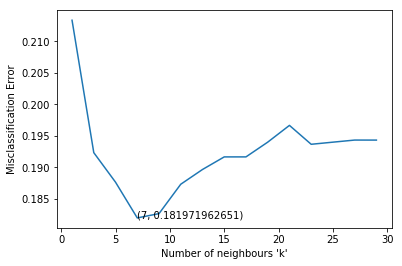

In [20]:
error = [1 - x for x in cv_scores]
optimal_k = klist[error.index(min(error))]
plt.plot(klist, error)
xy = (optimal_k, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()

In [21]:
# Accuracy on test data;
knn = KNeighborsClassifier(n_neighbors=optimal_k, n_jobs=-1)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
acc = accuracy_score(y_test, y_pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 7 is 80.600000%


## Training our own W2V :

In [22]:
# Splitting into Test, Train and Cross-Validation set -
x_train = sorted_sample[0:3000]
y_train = y[0:3000]
x_test = sorted_sample[3000:5000]
y_test = y[3000:5000]

print ("Training Set - ", x_train.shape)
print ("Test Set - ", x_test.shape)

Training Set -  (3000, 11)
Test Set -  (2000, 11)


In [23]:
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    sentence = sentence.decode('utf-8')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [24]:
import gensim
i=0
list_of_sent_train=[]
for sent in x_train['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

C:\Users\Prakhar\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [25]:
list_of_sent_test=[]
for sent in x_test['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [26]:
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=20, workers=4) 

## Avg-W2V :

In [27]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this train
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(20) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
    
print (len(sent_vectors_train))
print (len(sent_vectors_train[0]))

C:\Users\Prakhar\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


3000
20


In [28]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this test
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(20) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
    
print (len(sent_vectors_test))
print (len(sent_vectors_test[0]))

2000
20


In [29]:
klist = list(range(1,30,2))
klist

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

In [31]:
cv_scores = []
sent_vectors_train = np.array(sent_vectors_train)
sent_vectors_train = np.nan_to_num(sent_vectors_train)
for k in klist:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    scores = cross_val_score(knn, sent_vectors_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

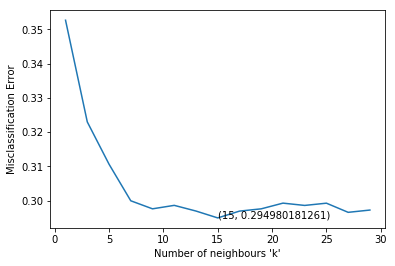

In [32]:
error = [1 - x for x in cv_scores]
optimal_k = klist[error.index(min(error))]
plt.plot(klist, error)
xy = (optimal_k, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()

In [33]:
# Accuracy on test data;
knn = KNeighborsClassifier(n_neighbors=optimal_k, n_jobs=-1)
knn.fit(sent_vectors_train, y_train)
y_pred = knn.predict(sent_vectors_test)
acc = accuracy_score(y_test, y_pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 15 is 71.050000%


## TF-IDF W2V :

In [34]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(x_train['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

In [35]:
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(20) # as word vectors are of zero length
    weight_sum = 0.0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
    
print (len(tfidf_sent_vectors_train))
print (len(tfidf_sent_vectors_train[0]))
print (tfidf_sent_vectors_train[0])

C:\Users\Prakhar\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in true_divide


3000
20
[-0.53850288 -0.29805557  0.15509758 -0.8186218   0.04861867 -0.02283562
 -0.86300649  0.61560783  0.19906589 -0.10934307 -0.48307782  0.67679467
 -0.08284813  0.08299234 -0.14526237  0.54557846 -0.19930756 -0.24469115
  0.60894899 -0.17126447]


In [36]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(20) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    
print (len(tfidf_sent_vectors_test))
print (len(tfidf_sent_vectors_test[0]))
print (tfidf_sent_vectors_test[0])

C:\Users\Prakhar\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in true_divide


2000
20
[-0.8643262  -0.43149044  0.22733403 -1.28753398  0.22133122 -0.19930944
 -1.32406216  1.14646437  0.27038476 -0.18071155 -0.86428224  1.21648543
 -0.22740578  0.06727403 -0.29902982  0.85998157 -0.3004119  -0.49709281
  0.85328    -0.25012354]


In [37]:
klist = list(range(1,30,2))
klist

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

In [39]:
cv_scores = []
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)
tfidf_sent_vectors_train = np.nan_to_num(tfidf_sent_vectors_train)
for k in klist:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    scores = cross_val_score(knn, tfidf_sent_vectors_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

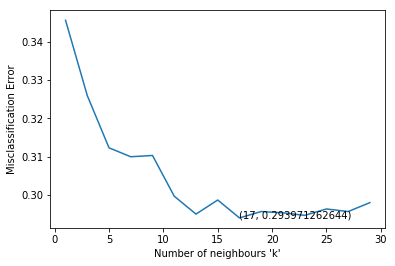

In [40]:
error = [1 - x for x in cv_scores]
optimal_k = klist[error.index(min(error))]
plt.plot(klist, error)
xy = (optimal_k, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()

In [41]:
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)
tfidf_sent_vectors_test = np.nan_to_num(tfidf_sent_vectors_test)

In [42]:
# Accuracy on test data;
knn = KNeighborsClassifier(n_neighbors=optimal_k, n_jobs=-1)
knn.fit(sent_vectors_train, y_train)
y_pred = knn.predict(tfidf_sent_vectors_test)
acc = accuracy_score(y_test, y_pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 17 is 57.400000%
